- colab

In [1]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip jena_climate_2009_2016.csv.zip

# import os
# fname = os.path.join('jena_climate_2009_2016.csv')

- m1 mac

In [2]:
import os
data_dir = './datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [3]:
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(f"header: \n{header}")
print(f"line length: {len(lines)}")

header: 
['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
line length: 420551


In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [5]:
# from matplotlib import pyplot as plt
# plt.plot(range(len(temperature)), temperature)
# plt.show()

In [6]:
# plt.plot(range(1440), temperature[:1440])
# plt.show()

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210275
num_val_samples: 105137
num_test_samples: 105139


In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
# TODO dataset01
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


2022-11-15 00:31:31.980474: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-15 00:31:31.980582: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-15 00:31:32.024135: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [10]:
# TODO dataset02
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [11]:
for samples, targets in train_dataset:
    print("sample shape:", samples.shape)
    print("target shape:", targets.shape)
    break

sample shape: (256, 120, 14)
target shape: (256,)


- 상식 수준의 기준점

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

검증 MAE: 2.44
테스트 MAE: 2.62


In [13]:
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

- 기본적인 머신 러닝 모델 시도 해보기

In [14]:
# inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# x = layers.Flatten()(inputs)
# x = layers.Dense(16, activation="relu")(x)
# outputs = layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)

# callbacks = [
#     keras.callbacks.ModelCheckpoint("jena_dense.keras",
#                                     save_best_only=True)
# ]
# model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
# history = model.fit(train_dataset,
#                     epochs=10,
#                     validation_data=val_dataset,
#                     callbacks=callbacks)

# model = keras.models.load_model("jena_dense.keras")
# print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [15]:
# loss = history.history["mae"]
# val_loss = history.history["val_mae"]
# epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, "bo", label="Training MAE")
# plt.plot(epochs, val_loss, "b", label="Validation MAE")
# plt.title("Training and validation MAE")
# plt.legend()
# plt.show()

In [16]:
# inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# x = layers.Conv1D(8, 24, activation="relu")(inputs)
# x = layers.MaxPooling1D(2)(x)
# x = layers.Conv1D(8, 12, activation="relu")(x)
# x = layers.MaxPooling1D(2)(x)
# x = layers.Conv1D(8, 6, activation="relu")(x)
# x = layers.GlobalAveragePooling1D()(x)
# outputs = layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)

# callbacks = [
#     keras.callbacks.ModelCheckpoint("jena_conv.keras",
#                                     save_best_only=True)
# ]
# model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
# history = model.fit(train_dataset,
#                     epochs=10,
#                     validation_data=val_dataset,
#                     callbacks=callbacks)

# model = keras.models.load_model("jena_conv.keras")
# print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [17]:
# loss = history.history["mae"]
# val_loss = history.history["val_mae"]
# epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, "bo", label="Training MAE")
# plt.plot(epochs, val_loss, "b", label="Validation MAE")
# plt.title("Training and validation MAE")
# plt.legend()
# plt.show()

In [18]:
# TODO LSTM
# TODO keras.Input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5


2022-11-15 00:31:41.511951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-15 00:31:41.767635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-15 00:31:42.047243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - ETA: 0s - loss: 40.7313 - mae: 4.6435

2022-11-15 00:32:17.321330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-15 00:32:17.462269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - 47s 55ms/step - loss: 40.7313 - mae: 4.6435 - val_loss: 12.4261 - val_mae: 2.6858
Epoch 2/5
819/819 [==============================] - 45s 55ms/step - loss: 10.9432 - mae: 2.5760 - val_loss: 9.8223 - val_mae: 2.4304
Epoch 3/5
819/819 [==============================] - 45s 55ms/step - loss: 9.7277 - mae: 2.4378 - val_loss: 9.7635 - val_mae: 2.4216
Epoch 4/5
819/819 [==============================] - 46s 56ms/step - loss: 9.3419 - mae: 2.3852 - val_loss: 9.7396 - val_mae: 2.4165
Epoch 5/5
819/819 [==============================] - 46s 56ms/step - loss: 9.0486 - mae: 2.3462 - val_loss: 9.5825 - val_mae: 2.3984


2022-11-15 00:35:29.923800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-15 00:35:30.066522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 12s 30ms/step - loss: 10.6809 - mae: 2.5653
테스트 MAE: 2.57


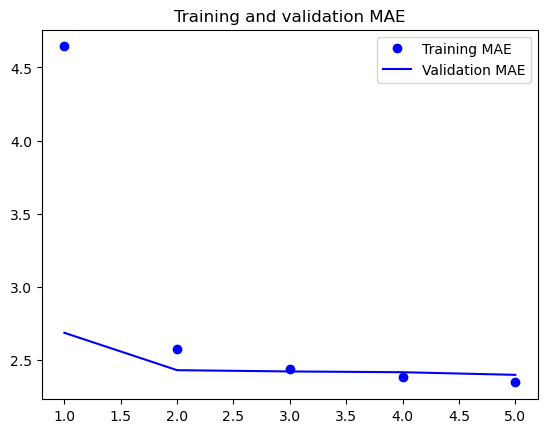

In [19]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()